# Evaluate HNN-family (HNN, D-HNN, DGNet) for 'experiment-real' problem

- by Jae Hoon (Daniel) Lee

In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import argparse
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

EXPERIMENT_DIR = './experiment-real'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset

In [2]:
def is_jupyter():
    return 'ipykernel' in sys.modules

In [3]:
def load_model_weights(model, filepath, device='cpu'):
    if not os.path.exists(filepath):
        print(f"Error: file not found: {filepath}")
        return

    try:
        state_dict = torch.load(filepath, map_location=torch.device(device))
        model.load_state_dict(state_dict)
        model.to(device)

        print(f"Model's weight has successfully been loaded: {filepath} (Device: {device})")
    
    except Exception as e:
        print(f"Error occurred while loading the model: {e}")


# DGNet (from discrete-autograd) Loader

In [4]:
import dgnet

In [5]:
def get_dgnet_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--noretry', dest='noretry', action='store_true', help='not do a finished trial.')
    # network, experiments
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--nonlinearity', default='tanh', type=str, help='neural net nonlinearity')
    parser.add_argument('--total_steps', default=2000, type=int, help='number of gradient steps')
    # display
    parser.add_argument('--print_every', default=200, type=int, help='number of gradient steps between prints')
    parser.add_argument('--verbose', dest='verbose', action='store_true', help='verbose?')
    parser.add_argument('--name', default='real', type=str, help='only one option right now')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--save_dir', default=EXPERIMENT_DIR, type=str, help='where to save the trained model')
    # model
    parser.add_argument('--model', default='hnn', type=str, help='used model.')
    parser.add_argument('--solver', default='dg', type=str, help='used solver.')
    parser.add_argument('--friction', default=False, action="store_true", help='use friction parameter')
    parser.set_defaults(feature=True)

    if is_jupyter():
        return parser.parse_args([]) 
    else:
        return parser.parse_args()

In [6]:
def get_dgnet_model(device='cpu'):

    args = get_dgnet_args()
    model = dgnet.DGNet(args.input_dim, args.hidden_dim,
                        nonlinearity=args.nonlinearity, friction=args.friction, model=args.model, solver=args.solver)
    model = model.to(device)
    return model

# D-HNN (Original version with MLP being different from the original HNN) Loader

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_dhnn_args(as_dict=False):
  arg_dict = {'input_dim': 3,
              'hidden_dim': 256, # capacity
              'output_dim': 2,
              'learning_rate': 1e-2, 
              'test_every': 100,
              'print_every': 200,
              'batch_size': 128,
              'train_split': 0.80,  # train/test dataset percentage
              'total_steps': 5000,  # because we have a synthetic dataset
              'device': 'cuda', # {"cpu", "cuda"} for using GPUs
              'seed': 42,
              'as_separate': False,
              'decay': 0}
  return arg_dict if as_dict else ObjectView(arg_dict)

In [8]:
def get_dhnn_model(device='cpu'):
    # Use Andrew Sosanya's implementation as-is.
    from dissipative_hnns.models import DHNN

    args = get_dhnn_args()

    model = DHNN(args.input_dim, args.hidden_dim) 
    model.to(device) 

    return model

# D-HNN2 (modified version to output Hamiltonian, based on the original HNN) Loader

In [9]:
"""
Modification of DHNN to DHNN2 architecture 
based on Sam Greydanus' original HNN implementation
"""
class MLP2(torch.nn.Module): 
    def __init__(self, input_dim, output_dim, hidden_dim):
      super(MLP2, self).__init__()
      self.lin_1 = nn.Linear(input_dim, hidden_dim)
      self.lin_2 = nn.Linear(hidden_dim, hidden_dim)
      self.lin_3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, t=None):
      inputs = torch.cat([x, t], axis=-1) if t is not None else x
      h = self.lin_1(inputs).tanh() 
      h = h + self.lin_2(h).tanh()
      y_hat = self.lin_3(h)
      return y_hat

class DHNN2(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DHNN2, self).__init__()
        # Since H and D are scalar, we set output_dim=1.
        self.mlp_h = MLP2(input_dim, 1, hidden_dim) 
        self.mlp_d = MLP2(input_dim, 1, hidden_dim) 
        # Levi-Civita permutation tensor M (HNN style)
        self.register_buffer('M', self.permutation_tensor(2))

    def forward(self, x, t=None): 
        """
        Inputs x and t, returns the scalar Hamiltonian (H) and Dissipation (D) functions.
        """
        inputs = torch.cat([x, t], axis=-1) if t is not None else x
        D = self.mlp_d(inputs)
        H = self.mlp_h(inputs)
        return H, D

    def time_derivative(self, x, t=None, as_separate=False):
        """
        Calculates the vector field (dx/dt) using gradients of H and D.
        """
        # Ensures gradient tracking, just like HNN.
        # x tensor should already have requires_grad=True!
        assert x.requires_grad, "Input tensor x must require grad for time_derivative calculation."

        H, D = self.forward(x, t) # output: H and D (scalar)

        # Gradient of H (Symplectic gradient)
        dHdx = torch.autograd.grad(H.sum(), x, create_graph=True)[0]
        # Computes the rotational component of the J * dHdx form (J: symplectic matrix)
        rot_component = dHdx @ self.M.t()

        # Gradient of D (Irrotational gradient)
        dDdx = torch.autograd.grad(D.sum(), x, create_graph=True)[0]
        irr_component = dDdx

        if as_separate:
            return irr_component, rot_component

        return irr_component + rot_component

    def permutation_tensor(self, n):
        # permutation_tensor implementation of the original HNN code
        M = torch.eye(n)
        # assuming canonical coordinates [q, p]
        M = torch.cat([M[n//2:], -M[:n//2]])
        return M

In [10]:
# simplifies accessing the hyperparameters.
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_dhnn2_args(as_dict=False):
  arg_dict = {'input_dim': 3,
              'hidden_dim': 256, # capacity
              'output_dim': 2,
              'learning_rate': 1e-2, 
              'test_every': 100,
              'print_every': 200,
              'batch_size': 128,
              'train_split': 0.80,  # train/test dataset percentage
              'total_steps': 5000,  # because we have a synthetic dataset
              'device': 'cuda', # {"cpu", "cuda"} for using GPUs
              'seed': 42,
              'as_separate': False,
              'decay': 0,
              'verbose': True}
  return arg_dict if as_dict else ObjectView(arg_dict)

In [11]:
def get_dhnn2_model(device='cpu'):
    args = get_dhnn2_args()    
    model = DHNN2(args.input_dim, args.hidden_dim) 
    model.to(device) 
    return model

# HNN (modified version for GPU-support) Loader

In [12]:
"""
Modification of HNN to the GPU trainable model HNN2
"""
class HNN2(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal',
                    baseline=False, assume_canonical_coords=True):
        super(HNN2, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.assume_canonical_coords = assume_canonical_coords
        self.field_type = field_type

        # --- Modification 1 for GPU support: register_buffer() is used ---
        # self.M = self.permutation_tensor(input_dim) # original HNN code
        M_tensor = self.permutation_tensor(input_dim)
        self.register_buffer('M_buffer', M_tensor) # M tensor is registered as buffer
        
    def forward(self, x):
        # traditional forward pass
        if self.baseline:
            return self.differentiable_model(x)

        y = self.differentiable_model(x)
        assert y.dim() == 2 and y.shape[1] == 2, "Output tensor should have shape [batch_size, 2]"
        return y.split(1,1)

    ''' 
    Omitted (out of the current interest).
       - rk4 function needs to be modified to GPU supporting version 
       - or torchdiffeq should be used
    '''
    # def rk4_time_derivative(self, x, dt):
    #    return rk4(fun=self.time_derivative, y0=x, t=0, dt=dt)'''

    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F1, F2 = self.forward(x) # traditional forward pass

        # --- Modification 2 for GPU support: In tensor creation, use x's device ---
        conservative_field = torch.zeros_like(x, device=x.device) # device=x.device added
        solenoidal_field = torch.zeros_like(x, device=x.device) # device=x.device added

        if self.field_type != 'solenoidal':
            dF1 = torch.autograd.grad(F1.sum(), x, create_graph=True)[0] # gradients for conservative field
            # self.M_buffer와 동일한 장치에 eye 생성
            eye = torch.eye(*self.M_buffer.shape, device=self.M_buffer.device)
            conservative_field = dF1 @ eye

        if self.field_type != 'conservative':
            dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
            # Use self.M_buffer
            solenoidal_field = dF2 @ self.M_buffer.t()

        if separate_fields:
            return [conservative_field, solenoidal_field]

        return conservative_field + solenoidal_field

    def permutation_tensor(self, n):
        # Returns torch tensor, and processed at __init__
        M = None
        if self.assume_canonical_coords:
            M = torch.eye(n)
            M = torch.cat([M[n//2:], -M[:n//2]])
        else:
            M = torch.ones(n,n)
            M *= 1 - torch.eye(n)
            M[::2] *= -1
            M[:,::2] *= -1
            for i in range(n):
                for j in range(i+1, n):
                    M[i,j] *= -1
        return M

In [13]:
def get_hnn2_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--nonlinearity', default='tanh', type=str, help='neural net nonlinearity')
    parser.add_argument('--total_steps', default=2000, type=int, help='number of gradient steps')
    parser.add_argument('--print_every', default=200, type=int, help='number of gradient steps between prints')
    parser.add_argument('--verbose', dest='verbose', action='store_true', help='verbose?')
    parser.add_argument('--name', default='real', type=str, help='name of the task')
    parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn')
    parser.add_argument('--baseline', dest='baseline', action='store_true', help='run baseline or experiment?')
    parser.add_argument('--use_rk4', dest='use_rk4', action='store_true', help='integrate derivative with RK4')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--save_dir', default=EXPERIMENT_DIR, type=str, help='where to save the trained model')
    parser.set_defaults(feature=True)

    if is_jupyter():
        return parser.parse_args([]) 
    else:
        return parser.parse_args()

In [14]:
def get_hnn2_model(device):
    """
    Definitions of MLP class at hamiltonian_nn and at dissipative_hnns DIFFER!
    We need hamitonian_nn's MLP implementation.
    """
    from hamiltonian_nn.nn_models import MLP

    args = get_hnn2_args()
    output_dim = args.input_dim
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    # Modified HNN class above (HNN2: GPU sersion) is used)
    model = HNN2(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type) 
    model.to(device) 
    return model

# Comparison among HNN2, D-HNN, D-HNN2, and DGNET

In [15]:
def load_model(model, filename, dir_path=None):
    if dir_path == None:
       dir_path = EXPERIMENT_DIR + "/weights"
    file_path = os.path.join(dir_path, filename)
    load_model_weights(model, file_path, 'cpu')

def load_hnn_family_models():
    args=get_dhnn2_args()

    hnn_model = get_hnn2_model('cpu')
    dhnn_model = get_dhnn_model('cpu')
    dhnn2_model = get_dhnn2_model('cpu') 
    dgnet_model = get_dgnet_model('cpu')

    load_model(hnn_model, filename='hnn2_real.pth')
    load_model(dhnn_model, filename='dhnn_real_with_midpts.pth')
    load_model(dhnn2_model, filename='dhnn2_real.pth')
    load_model(dgnet_model, filename='dgnet_real.pth')
    # load_model(dgnet_model,filename='dg-real-hnn-dg-friction-seed0.tar')
    
    return hnn_model, dhnn_model, dhnn2_model, dgnet_model

In [16]:
hnn2_model, dhnn_model, dhnn2_model, dgnet_model = load_hnn_family_models()

Model's weight has successfully been loaded: ./experiment-real/weights/hnn2_real.pth (Device: cpu)
Model's weight has successfully been loaded: ./experiment-real/weights/dhnn_real_with_midpts.pth (Device: cpu)
Model's weight has successfully been loaded: ./experiment-real/weights/dhnn2_real.pth (Device: cpu)
Model's weight has successfully been loaded: ./experiment-real/weights/dgnet_real.pth (Device: cpu)


In [17]:
# integrate along HNN vector field
from scipy.integrate import solve_ivp

def integrate_hnn2_model(model, t_span, y0, **kwargs):
    # auto detect current model's device (cuda:0).
    device = next(model.parameters()).device 

    def fun(t, np_x):
        x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
        # move input tensor to the same device
        x = x.view(1,2).to(device) 
        
        dx = model.time_derivative(x)
        
        # Before conversion to NumPy, move to cpu
        np_dx = dx.cpu().detach().numpy().reshape(-1) 
        return np_dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_dhnn_model(model, t_span, y0, **kwargs):
    device = next(model.parameters()).device 

    def fun(t, np_x):
        x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.zeros_like(x[...,:1])
        x.to(device), t.to(device)
        ''' Original D-HNN itself outputs time-derivative! '''
        dx = model(x, t=t)
        np_dx = dx.cpu().detach().numpy().reshape(-1)
        return np_dx
    
    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

def integrate_dhnn2_model(model, t_span, y0, **kwargs):
    device = next(model.parameters()).device 

    def fun(t, np_x):
        x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.zeros_like(x[...,:1])
        x.to(device), t.to(device)
        dx = model.time_derivative(x, t=t)
        np_dx = dx.cpu().detach().numpy().reshape(-1)
        return np_dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [18]:
def compute_orbits(t_span=20):
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'  # for comparison with HNN
    t_span = [0, t_span]
    trials = 5 * 3
    length = 100
    t_eval = np.linspace(t_span[0], t_span[1], length)

    args = get_dgnet_args()
    data = get_dataset('pend-real', args.save_dir)  # mid-pt rule 적용안하는 경우
    
    dtype = torch.get_default_dtype()
    test_x = torch.tensor(data['test_x'], requires_grad=True, device=device, dtype=dtype)

    t_eval = np.squeeze(data['test_t'] - data['test_t'].min())
    t_span = [t_eval.min(), t_eval.max()]

    x0_tensor = test_x[0] 
    x0 = x0_tensor.detach().cpu().numpy()

    true_x = test_x.detach().cpu().numpy()

    torch.set_grad_enabled(True)  # For HNN excution, needs to be set to True 
    hnn_path = integrate_hnn2_model(hnn2_model, t_span, x0, t_eval=t_eval)
    hnn_x = hnn_path['y'].T

    torch.set_grad_enabled(True)  # For D-HNN execution, needs to be set to True.
    dhnn_path = integrate_dhnn_model(dhnn_model, t_span, x0, t_eval=t_eval)
    dhnn_x = dhnn_path['y'].T

    torch.set_grad_enabled(True)  # For D-HNN execution, needs to be set to True.
    dhnn2_path = integrate_dhnn2_model(dhnn2_model, t_span, x0, t_eval=t_eval)
    dhnn2_x = dhnn2_path['y'].T

    torch.set_grad_enabled(False)  # For DGNet execution, needs to be set to False.
    dgnet_x = dgnet_model.get_orbit(x0, t_eval=t_eval)

    stats = {}
    stats['t_eval'] = t_eval
    stats['true_orbit'] = true_x
    stats['hnn_orbit'] = hnn_x
    stats['dhnn_orbit'] = dhnn_x
    stats['dhnn2_orbit'] = dhnn2_x
    stats['dgnet_orbit'] = dgnet_x
    stats['x0'] = x0
    
    return stats

In [19]:
stats = compute_orbits()

data zip filepath: ./experiment-real/invar_datasets.zip


/media/danieljh/shared/Code/piml-comp-git/assess-hamiltonian-nn-family/dgnet/modules.py:36: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x1 = fsolve(wrapped_func, to_numpy(x0), *args, **kwargs)


In [20]:
def save_plot_as_png(fig, title, experiment_dir='./experiment-pend'):
    save_dir = os.path.join(experiment_dir, 'compared')

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    filename = f"{title.replace(' ', '_')}.png"
    save_path = os.path.join(save_dir, filename)
    fig.savefig(save_path, bbox_inches='tight', dpi=150)
    print(f"Plot saved to: {save_path}")


In [21]:
from data import hamiltonian_fn

In [22]:
def plot_trajectory_compared(stats, hamiltonian_fn):
    device='cpu'
    dtype = torch.get_default_dtype()

    t_eval = stats['t_eval']
    true_x = stats['true_orbit']
    hnn_x = stats['hnn_orbit']
    dhnn_x = stats['dhnn_orbit']
    dhnn2_x = stats['dhnn2_orbit']
    dgnet_x = stats['dgnet_orbit']
    x0 = stats['x0']

    # plotting
    tpad = 7
    fig = plt.figure(figsize=(12, 12)) # 1x4 layout

    # Subplot 1: Predictions (Phase Space Trajectory)
    plt.subplot(2, 2, 1)
    plt.title("Orbit (Phase Space)\n"
              "(D-HNN : Original D-HNN trained with mid-pts)\n"
              "(D-HNN2 : D-HNN modified to output Hamiltonian)", pad=tpad) ; 
    plt.xlabel('$q$') ; plt.ylabel('$p$')
    plt.plot(true_x[:, 0], true_x[:, 1], 'k-', label='Truth', linewidth=1)
    plt.plot(hnn_x[:, 0], hnn_x[:, 1], 'b-', label='HNN', linewidth=1)
    plt.plot(dhnn_x[:, 0], dhnn_x[:, 1], color='orange', ls='-', label='D-HNN', linewidth=1)
    plt.plot(dhnn2_x[:, 0], dhnn2_x[:, 1], 'g-', label='D-HNN2', linewidth=1)
    plt.plot(dgnet_x[:, 0], dgnet_x[:, 1], 'r-', label='DGNet', linewidth=1)
    #plt.scatter(x0[0], x0[1], color='g', marker='o', s=100, label='Start Point')
    plt.axis('equal')
    plt.legend(fontsize=7)
    plt.grid(True)

    # Subplot 2: L2 Error over Time
    plt.subplot(2, 2, 2)
    plt.title("MSE beween coordinates\n"
              "(D-HNN : Original D-HNN trained with mid-pts)\n"
              "(D-HNN2 : D-HNN modified to output Hamiltonian)", pad=tpad) ; 
    plt.xlabel('Time step') ; plt.ylabel('L2 Error')
    plt.plot(t_eval, ((true_x-hnn_x)**2).mean(-1), 'k-', label='HNN', linewidth=1)
    plt.plot(t_eval, ((true_x-dhnn_x)**2).mean(-1), color='orange', ls='-', label='D-HNN', linewidth=1)
    plt.plot(t_eval, ((true_x-dhnn2_x)**2).mean(-1), 'b-', label='D-HNN2', linewidth=1)
    plt.plot(t_eval, ((true_x-dgnet_x)**2).mean(-1), 'r-', label='DGNet', linewidth=1)
    plt.legend(fontsize=7)
    plt.grid(True)

    # Subplot 3: Learned Energy H_model(u)
    plt.subplot(2, 2, 3)
    plt.title("Learned Hamiltonian H_model(u)\n"
              "(D-HNN : Original D-HNN does NOT output Hamiltonian.)\n"
              "(D-HNN2 : D-HNN modified to output Hamiltonian)", pad=tpad)
    plt.xlabel('Time step')

    with torch.no_grad():
        true_x_tensor = torch.tensor(true_x, requires_grad=False, device=device, dtype=dtype)
        hnn_x_tensor = torch.tensor(hnn_x, requires_grad=False, device=device, dtype=dtype)
        dhnn2_x_tensor = torch.tensor(dhnn2_x, requires_grad=False, device=device, dtype=dtype)
        dhnn2_t_tensor = torch.zeros_like(dhnn2_x_tensor[...,:1])
        dgnet_x_tensor = torch.tensor(dgnet_x, requires_grad=False, device=device, dtype=dtype)


        # energy predicted by the learned model
        ''' Original D-HNN does NOT output Hamiltonian ! '''
        hnn_true_hq = hnn2_model(true_x_tensor)[1].detach().cpu().numpy().squeeze()
        hnn_model_hq = hnn2_model(hnn_x_tensor)[1].detach().cpu().numpy().squeeze()
        dhnn2_true_hq = dhnn2_model(true_x_tensor, dhnn2_t_tensor)[1].detach().cpu().numpy().squeeze()
        dhnn2_model_hq = dhnn2_model(dhnn2_x_tensor, dhnn2_t_tensor)[1].detach().cpu().numpy().squeeze()
        dgnet_true_hq = dgnet_model.net(true_x_tensor).cpu().numpy().squeeze()
        dgnet_model_hq = dgnet_model.net(dgnet_x_tensor).cpu().numpy().squeeze()

    plt.plot(t_eval, hnn_true_hq, 'b-', label='H_hnn(True u)', linewidth=1)
    plt.plot(t_eval, hnn_model_hq, 'b--', label='H_hnn(HNN u)', linewidth=1)
    plt.plot(t_eval, dhnn2_true_hq, 'g-', label='H_dhnn2(True u)', linewidth=1)
    plt.plot(t_eval, dhnn2_model_hq, 'g--', label='H_dhnn2(D-HNN2 u)', linewidth=1)
    plt.plot(t_eval, dgnet_true_hq, 'r-', label='H_dgnet(True u)', linewidth=1)
    plt.plot(t_eval, dgnet_model_hq, 'r--', label='H_dgnet(DGNet u)', linewidth=1)
    
    plt.legend(fontsize=7)
    plt.grid(True)

    # Subplot 4: Total energy (True Hamiltonian H_true)
    plt.subplot(2, 2, 4)
    plt.title("True Hamiltonian H_true(u)\n"
              "(D-HNN : Original D-HNN trained with mid-pts)\n"
              "(D-HNN2 : D-HNN modified to output Hamiltonian)", pad=tpad)
    plt.xlabel('Time step')
    true_e = np.stack([hamiltonian_fn(c) for c in true_x])
    hnn_e = np.stack([hamiltonian_fn(c) for c in hnn_x])
    dhnn_e = np.stack([hamiltonian_fn(c) for c in dhnn_x])
    dhnn2_e = np.stack([hamiltonian_fn(c) for c in dhnn2_x])
    dgnet_e = np.stack([hamiltonian_fn(c) for c in dgnet_x])
    plt.plot(t_eval, true_e, 'k-', label='H_true(True u)', linewidth=1)
    plt.plot(t_eval, hnn_e, 'b-', label='H_true(HNN u)', linewidth=1)
    plt.plot(t_eval, dhnn_e, color='orange', ls='-', label='H_true(D-HNN u)', linewidth=1)
    plt.plot(t_eval, dhnn2_e, 'g-', label='H_true(D-HNN2 u)', linewidth=1)
    plt.plot(t_eval, dgnet_e, 'r-', label='H_true(DGNet u)', linewidth=1)
    plt.legend(fontsize=7)
    plt.grid(True)

    plt.tight_layout() ; 
   
    name = 'danieljh_plot_real_compared'

    save_plot_as_png(plt, name, EXPERIMENT_DIR)

    plt.show()

Plot saved to: ./experiment-real/compared/danieljh_plot_real_compared.png


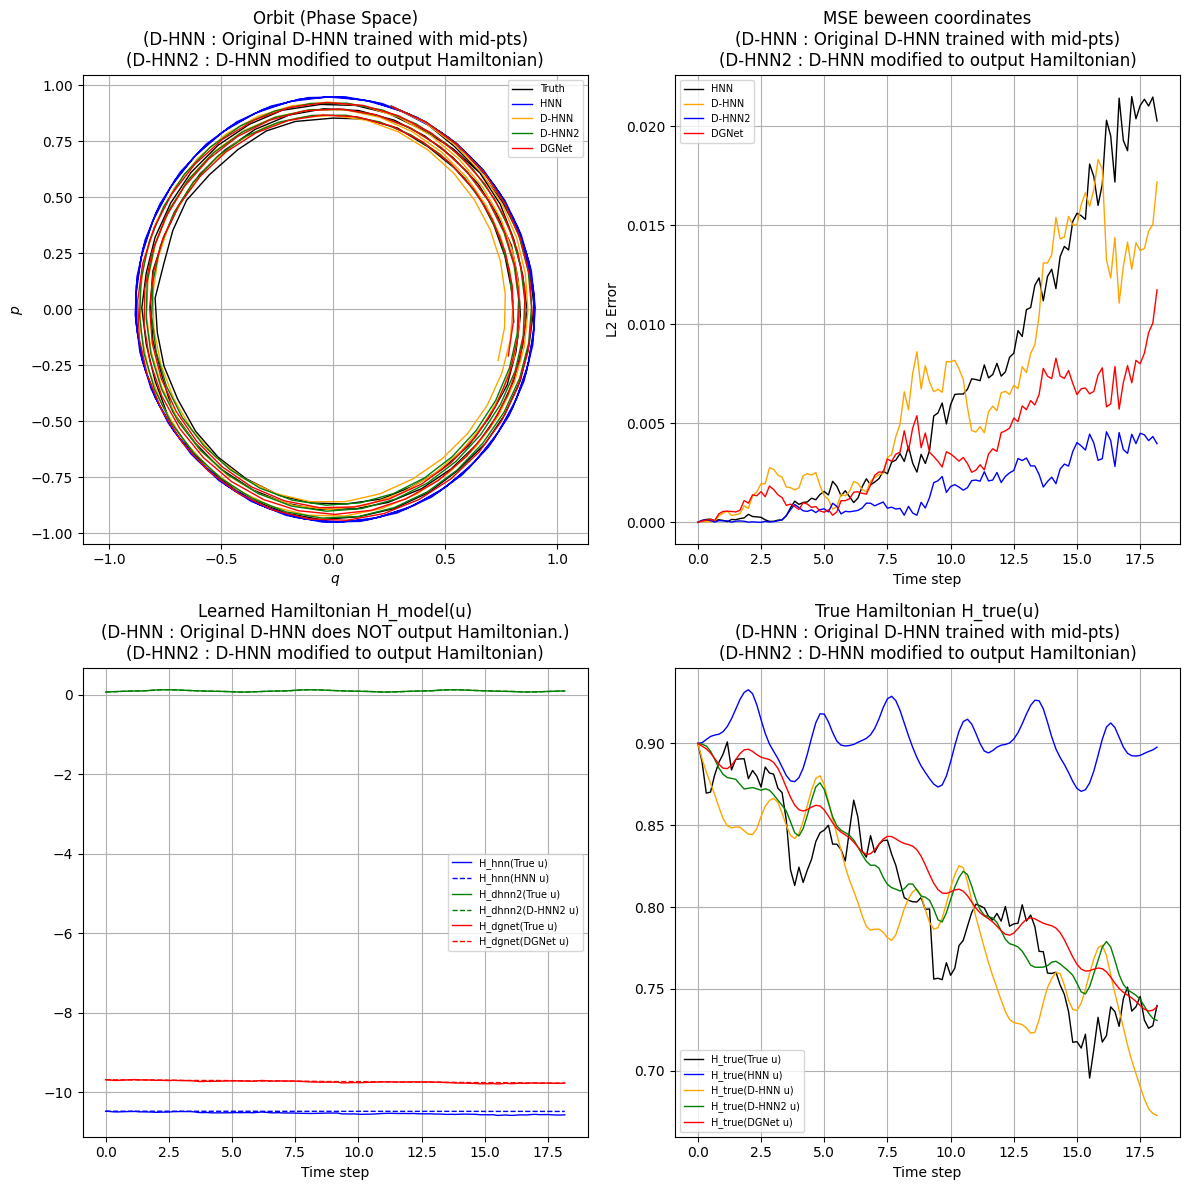

In [23]:
plot_trajectory_compared(stats, hamiltonian_fn)